# Visualize interpolation and smoothing

With this notebook, the output of the pose estimation can be visualized and filtered (if it is not interpolated and smoothed already). First execute the first two cells, then see the example in the third cell and explanations how to color a video with the output or how to plot the trajectories

For all filtering, interpolation etc., you can add this lines (with suitable data)

```bash
color_video(data, VIDEO_PATH, start = 0, cut_frame=False, end =len(data), printing = None, plotting=False, point = thickness)
```

underneath to save a video with the joints coloured on top

Put your path to json file, video file and where to put the output in the corresponding variable. thickness specifies the width of the plotted connections between joints.

In [1]:
import os
import sys
sys.path.append("..")

### SPECIFY THESE PATHS:

# This configuration would take the video and json file (containing the joint trajectories) 
# from the demo_data folder
# and output the coloured videos in a demo_output folder, with the name player_coloured.avi
VIDEO_PATH = os.path.join("..", "demo_data", "example_1.mp4")
JOINTS_PATH = os.path.join("..", "demo_data", "example_1_pitcher.json")
RAW_JOINTS_PATH = os.path.join("..", "demo_data", "example_1_raw.json")
OUT_PATH = os.path.join("..", "demo_data","demo_outputs","player_coloured.avi")
thickness = 2 # thickness of lines when plotting on a video (smaller for low quality videos)

## This configuration would use one of the high quality videos
# VIDEO_PATH = os.path.join("..", "train_data", "high_quality_videos","batter","#1 Kyle Zirbes.mp4")
# JOINTS_PATH = os.path.join("..", "train_data","batter_hq_joints", "#1 Kyle Zirbes.json")
# RAW_JOINTS_PATH = # no unprocessed joints available
# OUT_PATH = os.path.join("..", "train_data","batter_hq_joints","player_coloured.avi")
# thickness = 8 

In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import json
from scipy.signal import argrelextrema
from scipy import ndimage
import ast
from scipy.spatial.distance import cdist
from scipy.signal import butter, lfilter, freqz, group_delay, filtfilt
from skvideo import io

from os import listdir
import math
import pandas as pd
from scipy.interpolate import interp1d

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [3]:
layer_list = [0]
joints_for_cdist = np.arange(0,18,1)
important_joints = [0,3,6,7,8,9,10,11]
limbSeq = [[0,1], [1,2], [0,3], [3,4], [4,5], [6,9],[6,7], [7,8],[9,10],[10,11], [0,6], [3,9]]
colors = [[255, 0, 0], [120, 0, 0], [255, 255, 0], [255, 120, 0], [200, 100, 0], [120, 120, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
joints_list = ["right shoulder", "right elbow", "right wrist", "left shoulder","left elbow", "left wrist",
            "right hip", "right knee", "right ankle", "left hip", "left knee", "left ankle", "neck",
            "right eye", "right ear","left eye", "left ear"]

def color_video(json_array, vid_file, start = 0, cut_frame = True, end = 300, point = 8, printing =None, plotting=True):
    video_capture = cv2.VideoCapture(vid_file)
    arr=[]        
    for j in range(start, end):
        ret, canvas = video_capture.read()
        if canvas is None:
            print("end", j)
            break
                
        for i, inds in enumerate(limbSeq):
            if inds[0]>11 or inds[1]>11:
                continue
            Y = json_array[j,inds, 0]
            X = json_array[j,inds, 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            cur_canvas = canvas.copy()
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), point), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.1, cur_canvas, 0.9, 0)
        arr.append(canvas[:,:,[2,1,0]])
    arr = np.array(arr)
    io.vwrite(OUT_PATH, arr) # WRITE VIDEO

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck",
            "right_eye", "right_ear","left_eye", "left_ear"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            # print("liste",list(fr.keys()), "joint", j, "in dic?", str(j) in list(fr.keys()), list(fr.keys())[-1])
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)
    return np.array(liste)



def plot_x_and_y(data):
    fig = plt.figure(figsize=(20,10))
    fig.add_subplot(121)
    for l in range(len(data[0])):
        plt.plot(data[:,l,0], label = joints_list[l])
    plt.ylabel("X coordinates", fontsize=20)
    plt.xlabel("Frame", fontsize=20)
    # plt.ylim(475,275)
    plt.legend(fontsize=15)
    # plt.show()
    
    fig.add_subplot(122)
    # plt.figure(figsize=(20,10))
    for l in range(len(data[0])):
        plt.plot(data[:,l,1], label = joints_list[l])
    plt.ylabel("Y coordinates", fontsize=20)
    plt.xlabel("Frame", fontsize=20)
    plt.legend(fontsize=15)
    plt.ylim(np.max(data[:,:,1]), np.min(data[:,:,1]))
    plt.show()

## Just color one video with the output:

### The joints are coloured in each frame, and this is saved as a video file again in the specified output directory

For high quality videos this should be around 8, for low quality videos it should be 2


json file loaded array shape (166, 12, 2)


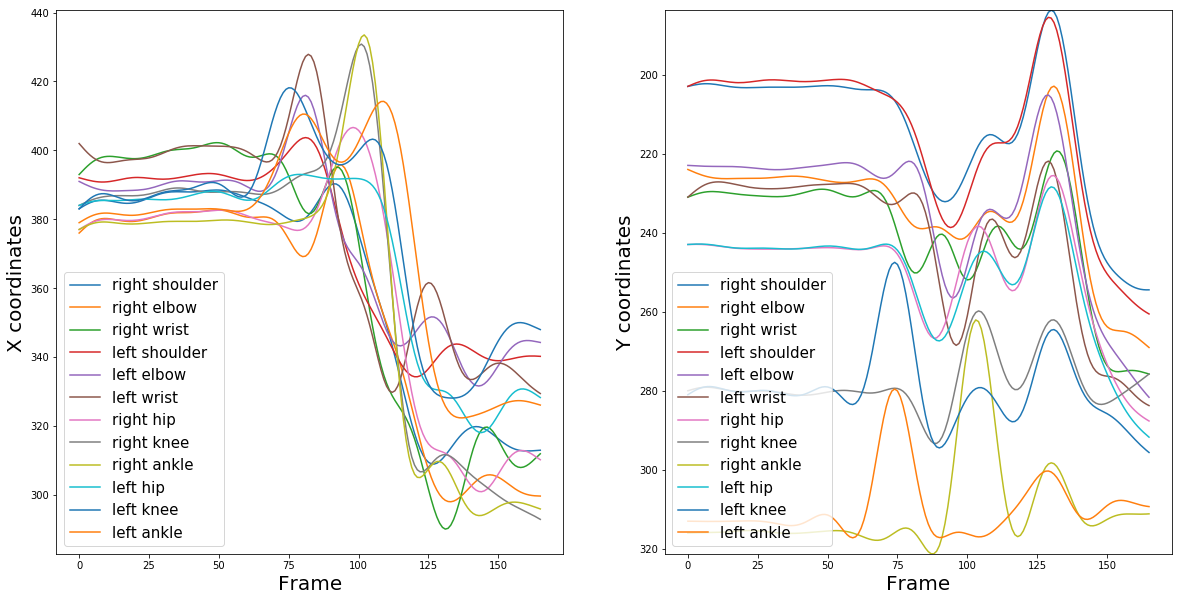

In [4]:
# json file is loaded and converted to a numpy array
joint_trajectories = from_json(JOINTS_PATH)
print("json file loaded", "array shape", joint_trajectories.shape)


plot_x_and_y(joint_trajectories)

# TO PLOT IT ON VIDEO AND SAVE THE VIDEO
color_video(joint_trajectories[:,:12,:], VIDEO_PATH, start = 0, cut_frame=False, end =len(joint_trajectories), printing = None, plotting=False, point = thickness)

# Visualize interpolation and filtering functions

## Raw data and interpolation

In [9]:
from utils_filtering.filtering_and_dtak import *

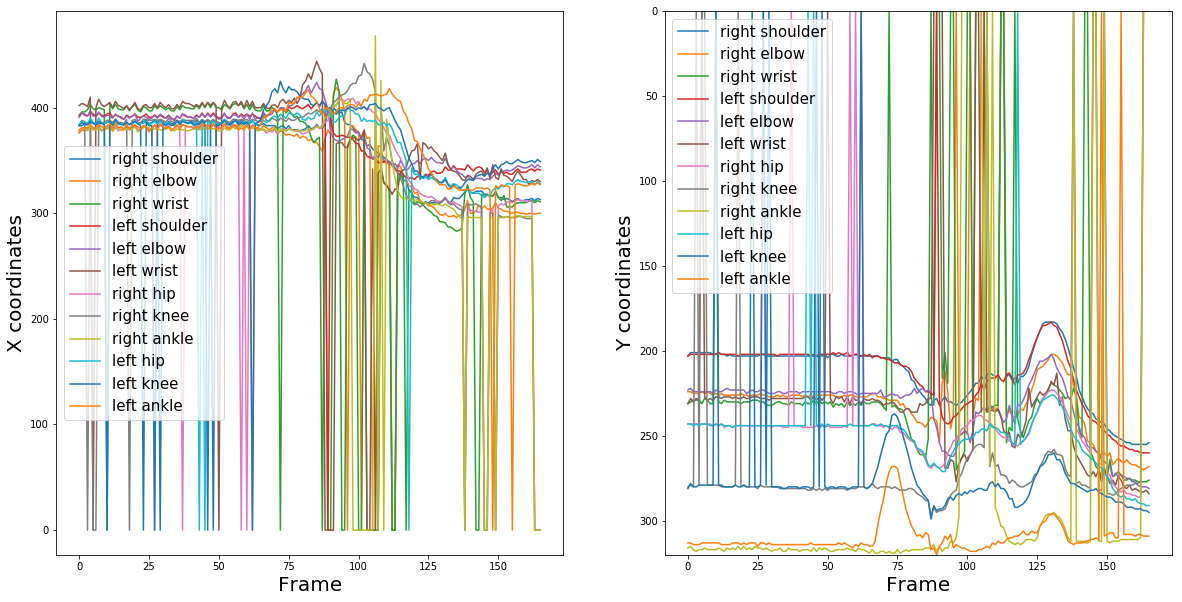

------------------ INTERPOLATED-----------------------


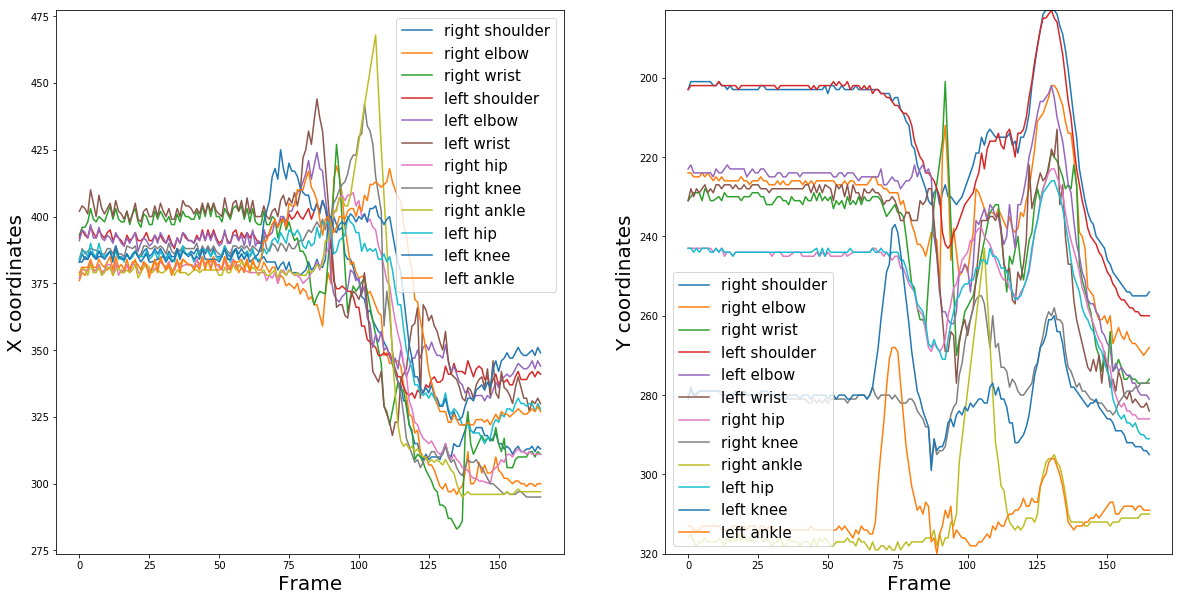

In [10]:
raw_data = from_json(RAW_JOINTS_PATH)

plot_x_and_y(raw_data)

def interpolate(mat, erosion = False):
    """
    returns interpolated version of mat, with all 0 removed (linear interpolation)
    mat: array of size frames * num_joints * number_coordinates
    erosion: if it is likely that there is noise with single misdetections, erode such that isolated points between missing values are removed
    """
    frames, num_joints, xy_len = mat.shape

    for limb in range(num_joints):
        for xy in range(xy_len): # x and y coord dimension
            values = mat[:, limb, xy]
            not_zer = np.logical_not(values == 0)
            indices = np.arange(len(values))

            if not any(not_zer): # everything is zero, so can't interpolate
                mat[:, limb, xy] = 0
                print("whole joint is zero")
            else:
                mat[:, limb, xy] = np.round(np.interp(indices, indices[not_zer], values[not_zer]), 1) # linear interpolation
    return mat

print("------------------ INTERPOLATED-----------------------")

interpolated = interpolate(raw_data.copy())
plot_x_and_y(interpolated)

## Kalmann filtering

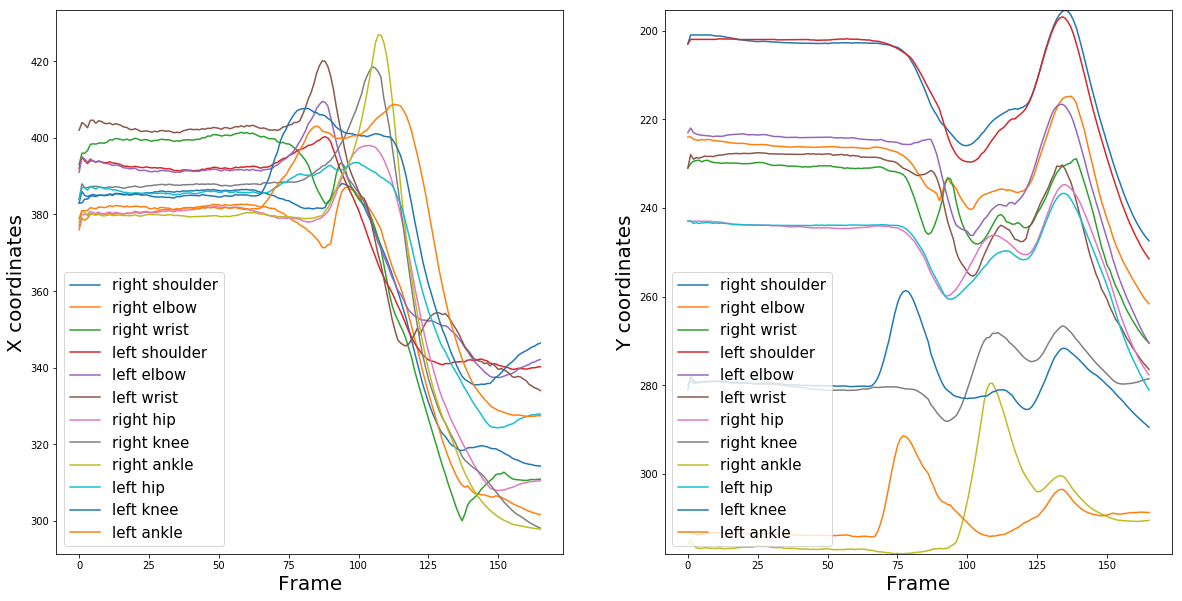

In [11]:
filtered = interpolated.copy()
for k in range(len(filtered[0])):
    for j in range(2):
        filtered[:,k,j] = kalmann(filtered[:,k,j])  

plot_x_and_y(filtered)

## Butterworth lowpass filtering

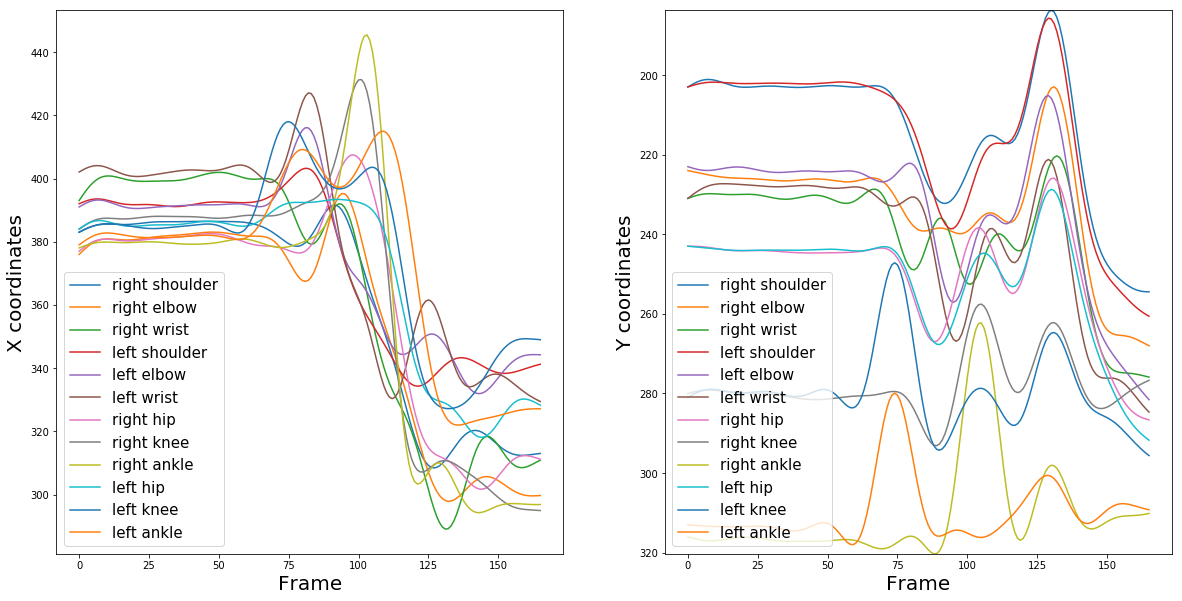

In [12]:
filtered = interpolated.copy()
fps = 20
for k in range(len(filtered[0])):
    for j in range(2):
        filtered[:,k,j] = lowpass(filtered[:,k,j]-filtered[0,k,j], cutoff = 1, fs = fps)+filtered[0,k,j]  

plot_x_and_y(filtered)

## Gaussian, hamming and blackman filtering

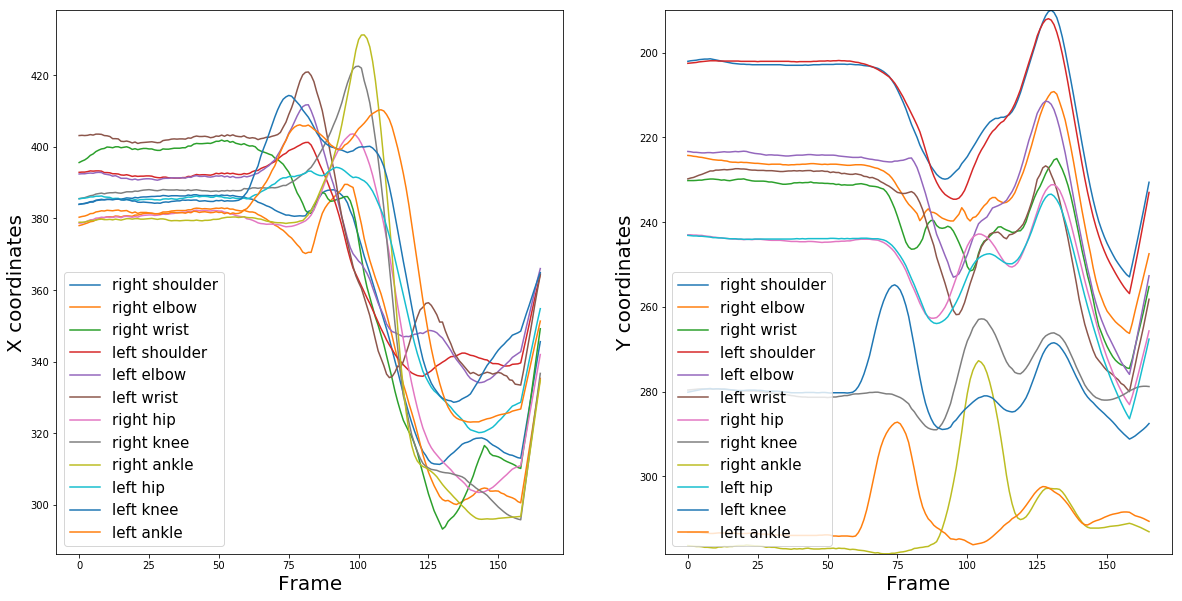

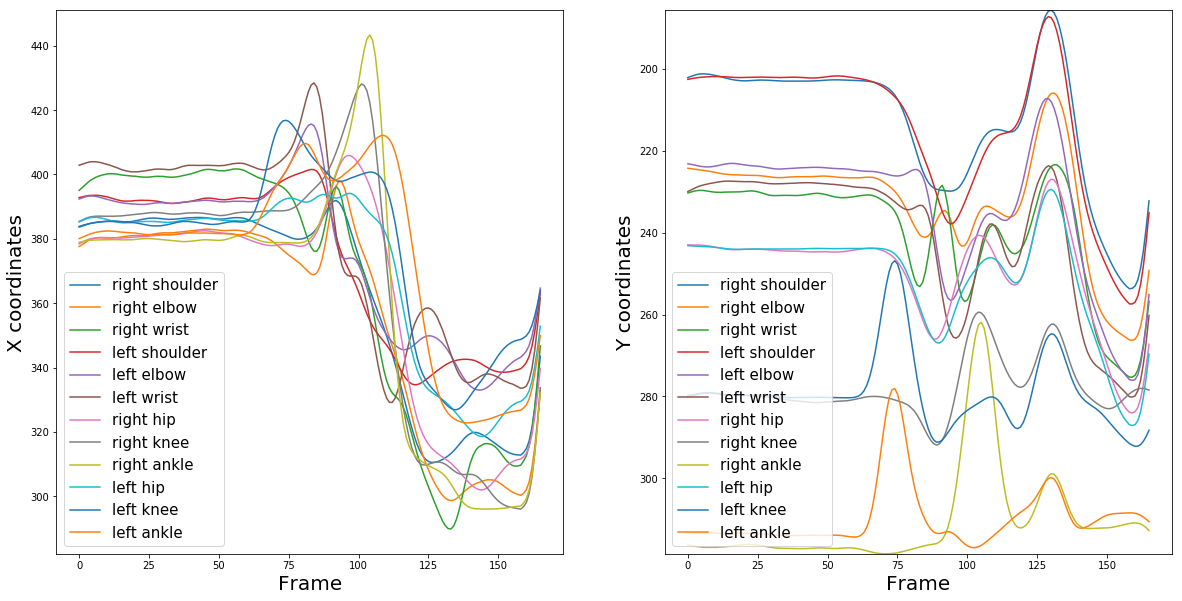

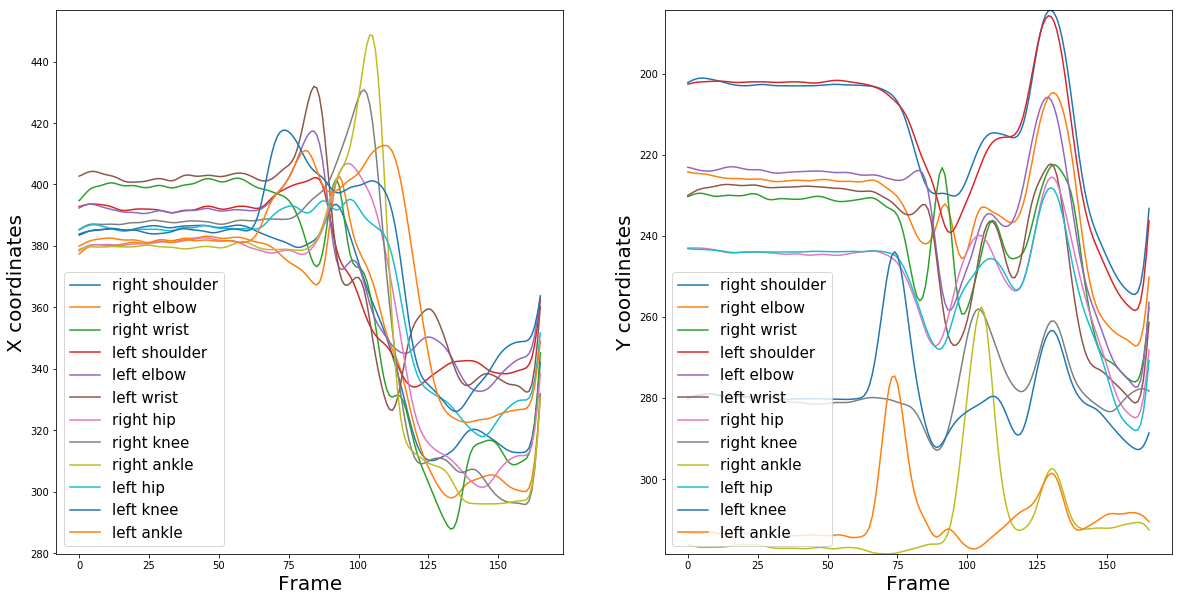

In [13]:
# FLAT
flat = interpolated.copy()
for k in range(len(flat[0])):
    for j in range(2):
        flat[:,k,j] = smooth(flat[:,k,j]-flat[0,k,j],window_len=15,window='flat')+flat[0,k,j]  

plot_x_and_y(flat)

# HAMMING
hamming = interpolated.copy()
for k in range(len(hamming[0])):
    for j in range(2):
        hamming[:,k,j] = smooth(hamming[:,k,j]-hamming[0,k,j],window_len=15,window='hamming')+ hamming[0,k,j] 

plot_x_and_y(hamming)

#BLACKMAN
blackman = interpolated.copy()
for k in range(len(blackman[0])):
    for j in range(2):
        blackman[:,k,j] = smooth(blackman[:,k,j]-blackman[0,k,j],window_len=15,window='blackman')+ blackman[0,k,j] 

plot_x_and_y(blackman)

## Bspline fitting

NOTE THAT BSPLINE FITTING DOES NOT REQUIRE INTERPOLATION BEFORE! (RAW DATA IS USED AS INPUT)

In [15]:
from utils_filtering.bspline_fitting import *

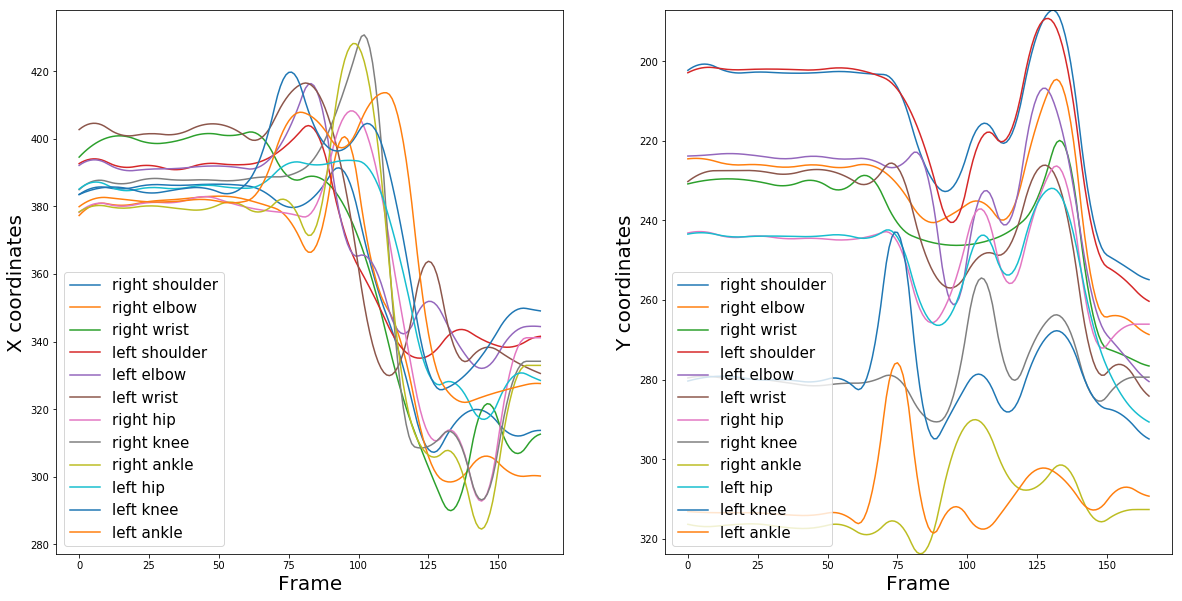

In [16]:
filtered = raw_data.copy()
filtered = filter_bspline(filtered, knot_dist=10)
plot_x_and_y(filtered)

## To color video:
color_video(filtered, VIDEO_PATH, start = 0, cut_frame=False, end =len(filtered), printing = None, plotting=False, point = thickness)